In [19]:
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from scipy import stats
import seaborn as sns
from skbio.stats.composition import clr
from sklearn.preprocessing import normalize
from sklearn.utils import resample
import time
import warnings
warnings.filterwarnings("ignore", message="FutureWarning")

import sys
sys.path.append('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/libraries')
from survival import *
from clinical import load_clinical
from data_processing import *
from forest_plots import *

### Forest plots

In [20]:
# data_dir = '/mnt/cephfs/sharedscratch/users/krakovic/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/LATTICeA_5x/h224_w224_n3_zdim128_filtered/rapids_2p5m/rapids_2p5m_leiden_2.5_l1ratio_0p2_mintiles_100_os_event_ind_20241126_174844_new_stroma_HPL_vectors/'
data_dir = '/mnt/cephfs/sharedscratch/users/krakovic/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/LATTICeA_5x/h224_w224_n3_zdim128_filtered/rapids_2p5m/rapids_2p5m_leiden_2.5_l1ratio_0p2_mintiles_100_os_event_ind_20241126_17335_new_tumour_HPL_vectors/'
# data_dir = '/mnt/cephfs/sharedscratch/users/krakovic/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/LATTICeA_5x/h224_w224_n3_zdim128_filtered/rapids_2p5m/rapids_2p5m_leiden_2.5_l1ratio_0p2_mintiles_100_os_event_ind_20241126_155025_all_abnormal_HPL_vectors/'
summaries = [pd.read_csv(os.path.join(data_dir, f'os_event_ind_fold_{i}.csv')) for i in range(5)]

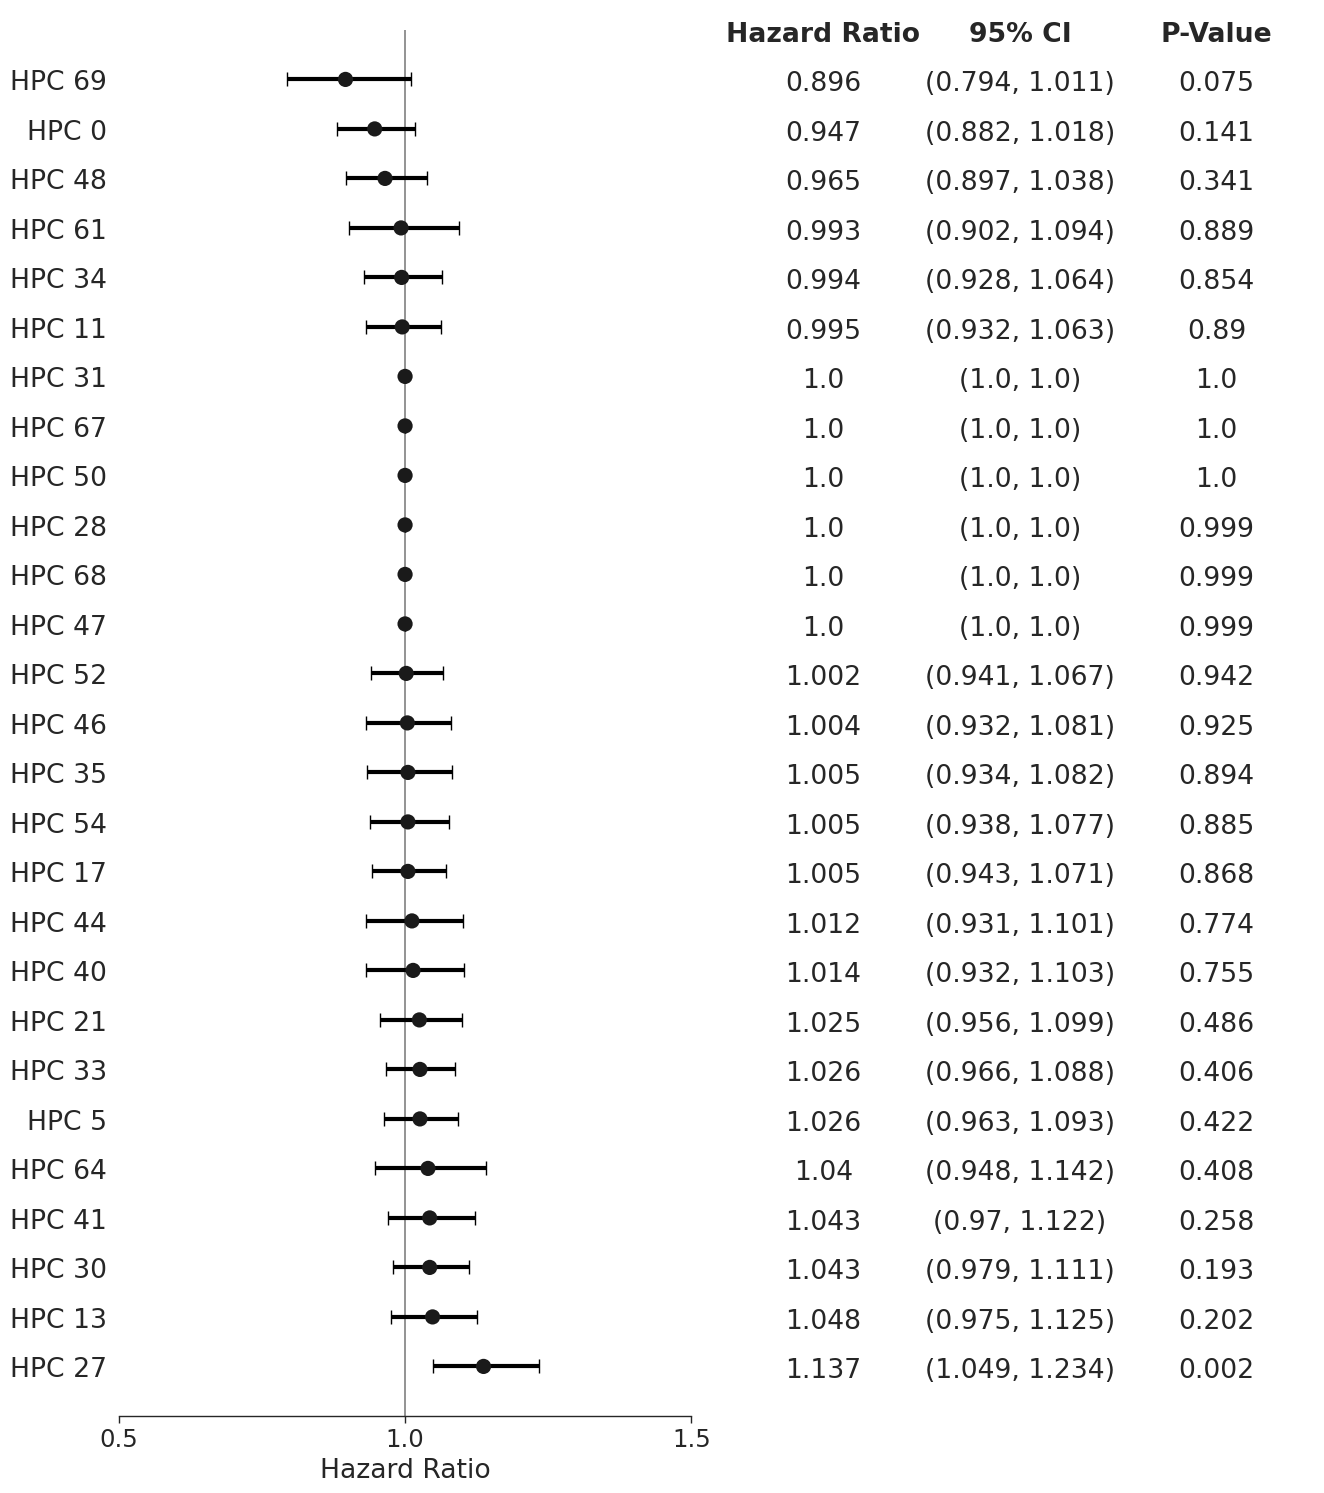

In [21]:
summary = summaries[0].copy(deep=True).set_index('covariate')

summary.index = [f'HPC {c}' for c in summary.index.values]
summary.index.name = 'covariate'
# summary.drop(labels='covariate', inplace=True, axis=1)

summary
forest_plots(frame=summary, scale_to_plot='exp', fold=0, event_ind_col='os_event_ind', save_path=None)

In [22]:
all_summaries = pd.concat([summaries[i] for i in range(5)])
counts = np.array([752, 753, 753, 753, 753])
cox_coef_pvals = all_summaries[['covariate', 'p']].copy(deep=True)
cox_coef       = all_summaries[['covariate', 'coef']].copy(deep=True)
cox_coef_se    = all_summaries[['covariate', 'se(coef)']].copy(deep=True)
all_summaries = all_summaries.groupby('covariate').mean().reset_index()
all_summaries = all_summaries.sort_values(by='covariate')

avgs = list()
ses  = list()
for i in all_summaries['covariate']:
    average = np.average(cox_coef[cox_coef['covariate']==i]['coef'].values, weights=counts)
    std = np.sqrt(np.sum((counts - 1) * (cox_coef_se[cox_coef_se['covariate']==i]['se(coef)'].values**2))/(np.sum(counts)-counts.shape[0]))
    avgs.append(average)
    ses.append(std)
all_summaries['coef'] = avgs
all_summaries['se']   = ses
all_summaries['coef lower 95%'] = all_summaries['coef'] - (1.95996*all_summaries['se'])
all_summaries['coef upper 95%'] = all_summaries['coef'] + (1.95996*all_summaries['se'])

all_summaries['p'] = cox_coef_pvals.groupby('covariate').apply(lambda x: stats.combine_pvalues(x['p'], method='fisher')[1]).reset_index()[0]
all_summaries = all_summaries.sort_values(by='coef')
all_summaries = all_summaries.set_index('covariate')
all_summaries.index = [f'HPC {c}' for c in all_summaries.index.values]
all_summaries.index.name = 'covariate'

all_summaries

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p),se
covariate,,,,,,,,,,,
HPC 69,-9.143486e-02,0.912728,0.060699,-0.210477,0.027607,0.810411,1.027981,-1.499727,2.642909e-02,2.930518,0.060737
HPC 0,-6.340027e-02,0.938595,0.035422,-0.132961,0.006160,0.875644,1.006090,-1.800771,2.956458e-03,3.844942,0.035491
HPC 48,-3.259174e-02,0.967962,0.037511,-0.106142,0.040958,0.899348,1.041816,-0.871419,4.612673e-01,1.408920,0.037526
HPC 61,-1.462880e-02,0.985505,0.049015,-0.110712,0.081455,0.895246,1.084868,-0.296521,9.871847e-01,0.393065,0.049023
HPC 11,-1.302853e-02,0.987125,0.025089,-0.068028,0.041971,0.940197,1.037032,-0.418622,9.261412e-01,0.638402,0.028061
HPC 34,-9.902549e-03,0.990241,0.027146,-0.069365,0.049560,0.939371,1.044608,-0.303271,9.704989e-01,0.490000,0.030339
HPC 67,-1.217854e-03,0.998786,0.007250,-0.032635,0.030199,0.985140,1.013413,-0.033915,9.999995e-01,0.042297,0.016029
HPC 50,-2.099341e-07,1.000000,0.000305,-0.000757,0.000756,0.999402,1.000598,-0.000591,1.000000e+00,0.000768,0.000386
HPC 28,1.534842e-08,1.000000,0.000115,-0.000228,0.000228,0.999774,1.000226,0.000171,1.000000e+00,0.000820,0.000116


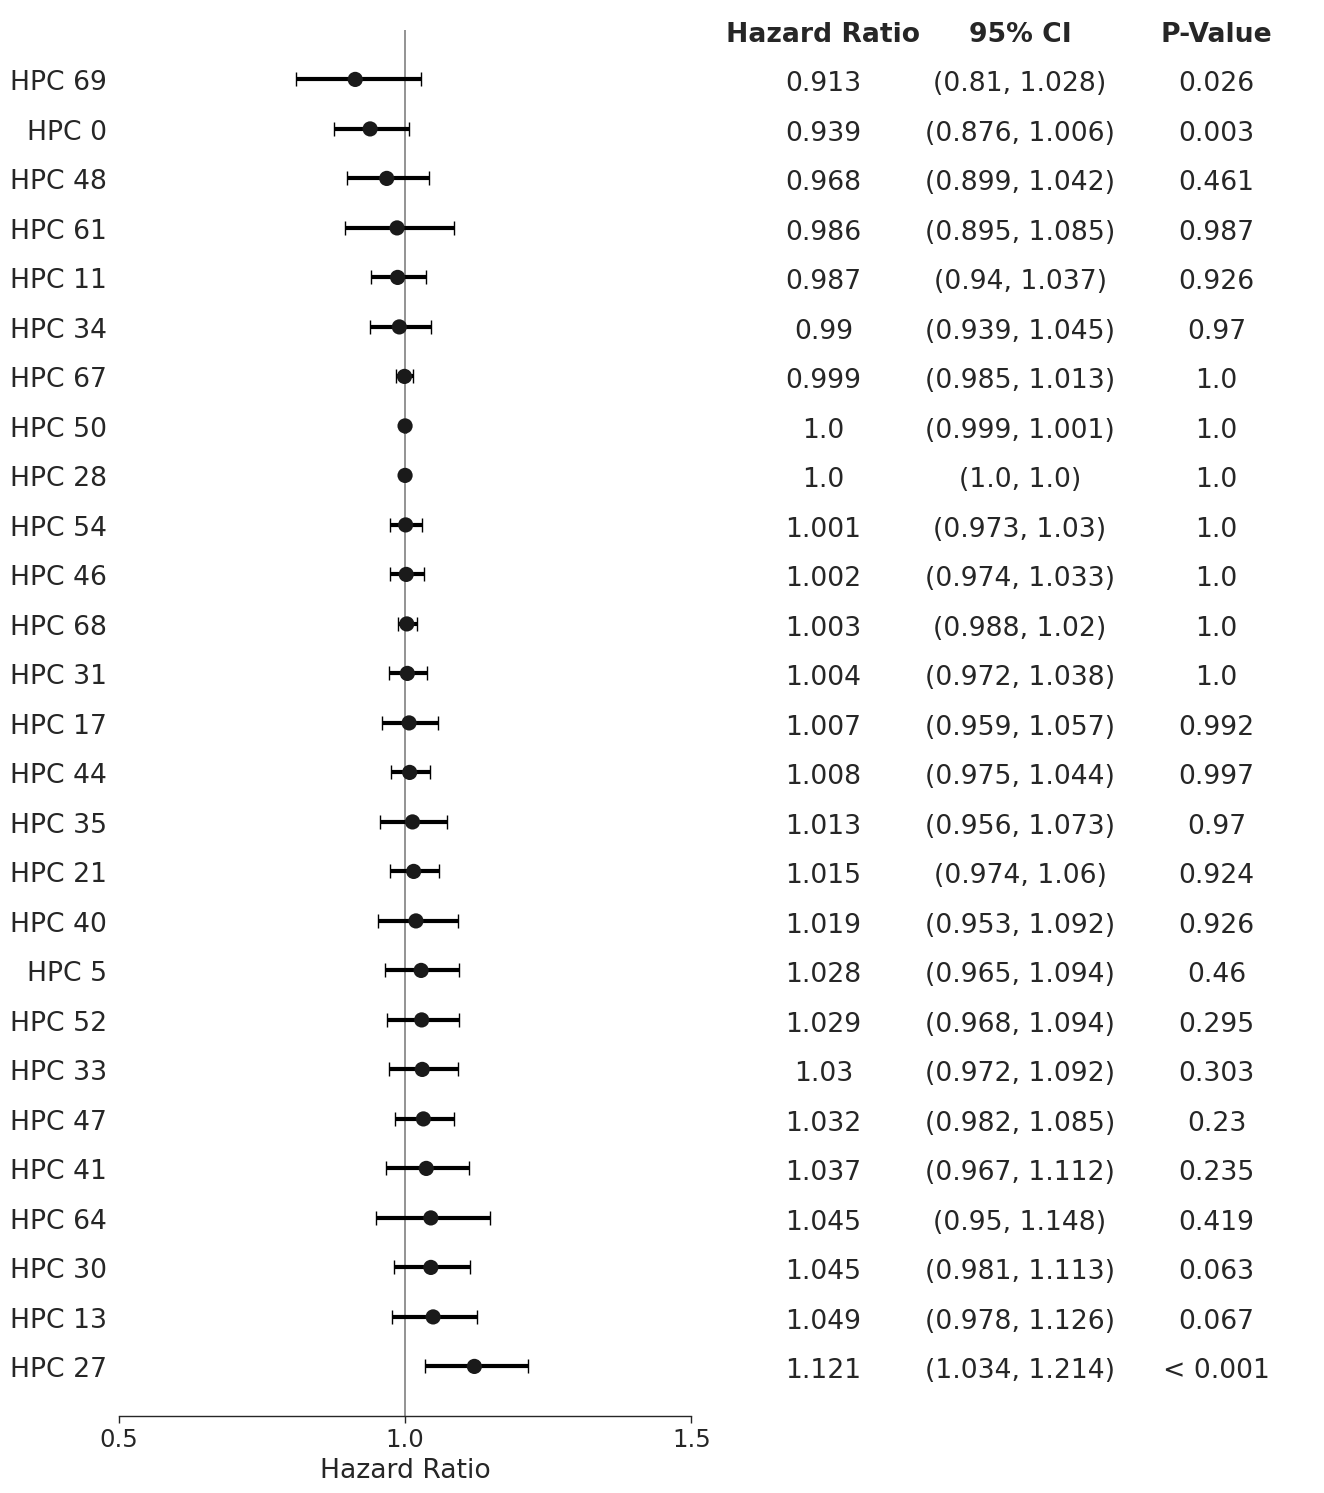

In [23]:
forest_plots(frame=all_summaries, scale_to_plot='exp', fold=0, event_ind_col='os_event_ind', save_path=None)

In [24]:
# all_summaries.to_csv(os.path.join(data_dir, 'all_folds_summary.csv'))

### KMs for manuscript

In [9]:
# High-Low risk groups and KMs
import pandas as pd
import os
import seaborn as sns

alpha_path = '/mnt/cephfs/sharedscratch/users/krakovic/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/LATTICeA_5x/h224_w224_n3_zdim128_filtered/rapids_2p5m/rapids_2p5m_leiden_2.5_l1ratio_0p2_mintiles_100_os_event_ind_20241126_17335_new_tumour_HPL_vectors/'

high_low = list()

for fold in range(5):
    high_low_frame = pd.read_csv(os.path.join(alpha_path, f"high_low_fold_{fold}.csv"))
    high_low.append(high_low_frame)

In [10]:
print(f"Train: {high_low[1][high_low[1]['original_set'] == 'train'].shape[0]}")
print(f"Test: {high_low[1][high_low[1]['original_set'] == 'test'].shape[0]}")
print(f"Additional: {high_low[1][high_low[1]['original_set'] == 'additional'].shape[0]}")

Train: 753
Test: 188
Additional: 339


p = 0.001
p < 0.001
p < 0.001
p = 0.017
p < 0.001


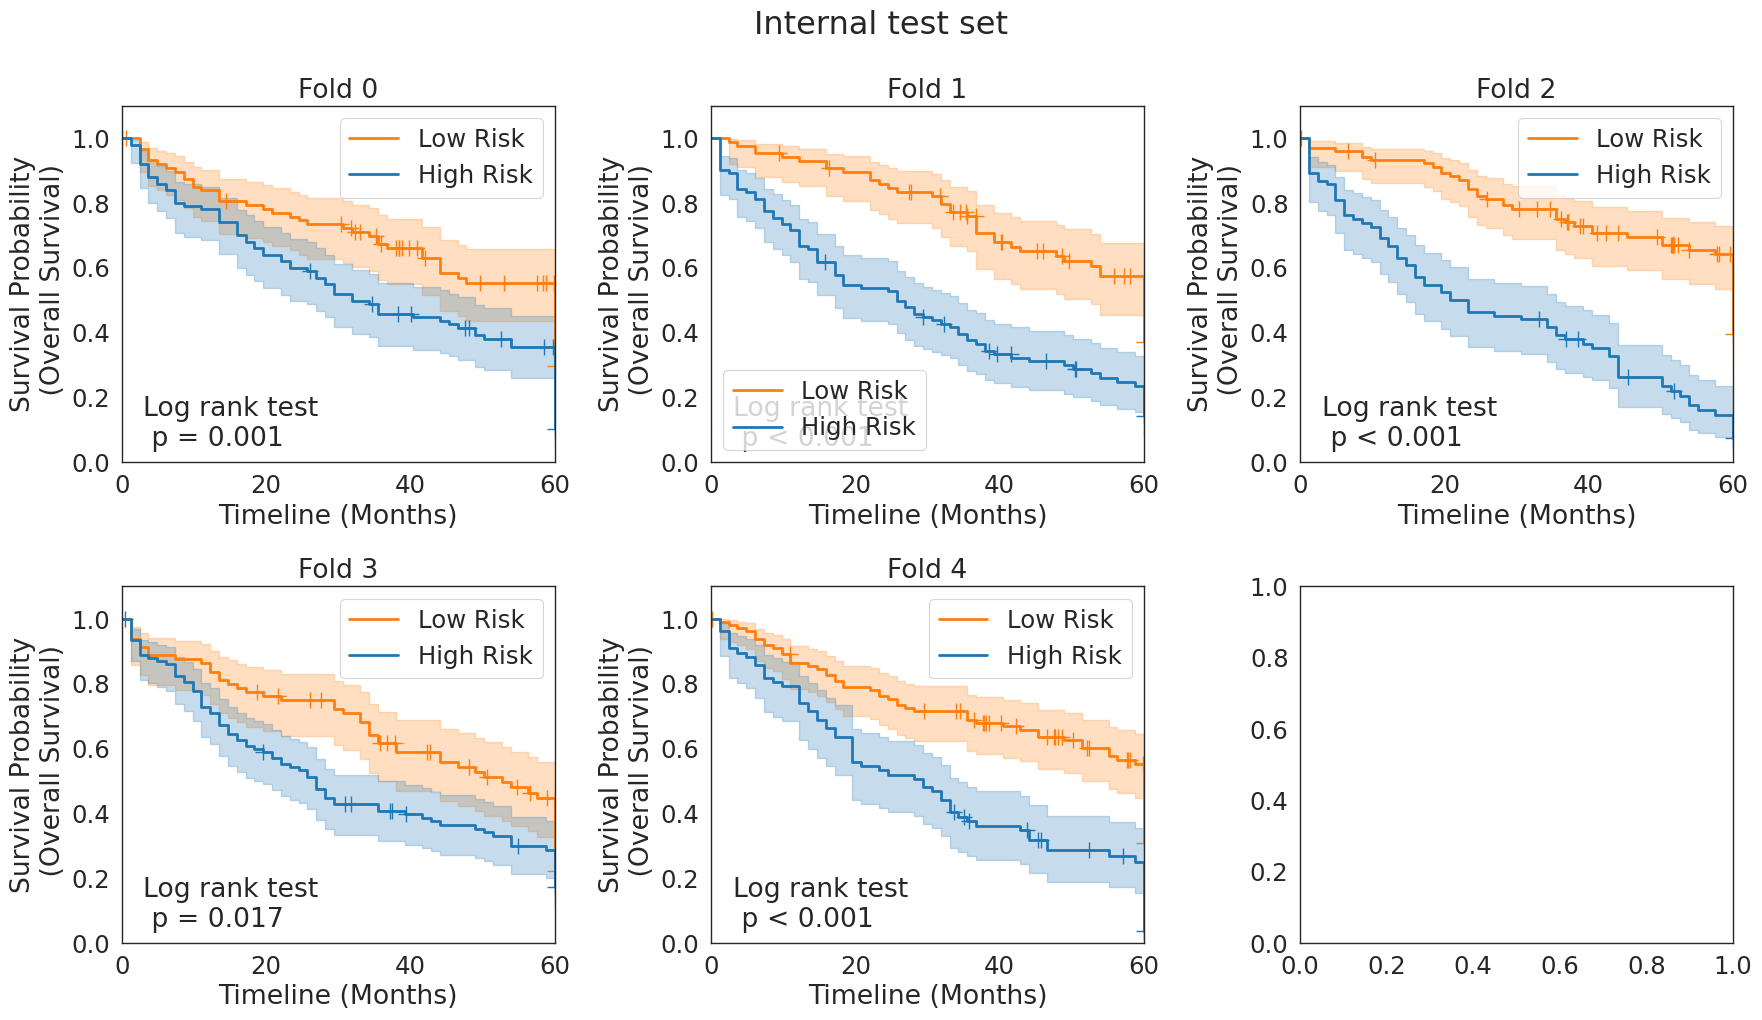

In [26]:
event_ind_field = 'os_event_ind'
event_data_field = 'os_event_data'

sns.set_theme(style='white')
sns.set_context(context='paper', font_scale=2.0)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,10.5))
axs = axs.flatten()

for i in range(5):
    risk_groups = high_low[i]
    risk_groups = risk_groups[risk_groups['original_set'] == 'test']
    plot_km_two_groups(risk_groups, event_ind_field, event_data_field, f'h_bin_{i}', 60, add_counts=False, title=f'Fold {i}', ax=axs[i])
# plot_km_two_groups(additional_risk_groups, event_ind_field, event_data_field, 'risk', 60, title='External test set', ax=ax2)

plt.suptitle('Internal test set')
plt.tight_layout()
plt.show()

In [8]:
sns.set_context("paper", font_scale=2.5)
fig, ax = plt.subplots(figsize=(9,8))
fold = 1

risk_groups = high_low[fold]
risk_groups = risk_groups[risk_groups['original_set'] == 'test']
plot_km_two_groups(risk_groups, event_ind_field, event_data_field, f'h_bin_{fold}', 60, add_counts=False, title='LATTICeA (test)', ax=ax)


NameError: name 'sns' is not defined

In [12]:
risk_groups = high_low[fold]
risk_groups = risk_groups[risk_groups['original_set'] == 'test']

risk_groups[f'h_bin_{fold}'].value_counts()


0    111
1     77
Name: h_bin_4, dtype: int64

p < 0.001
p = 0.002
p < 0.001
p < 0.001
p = 0.001


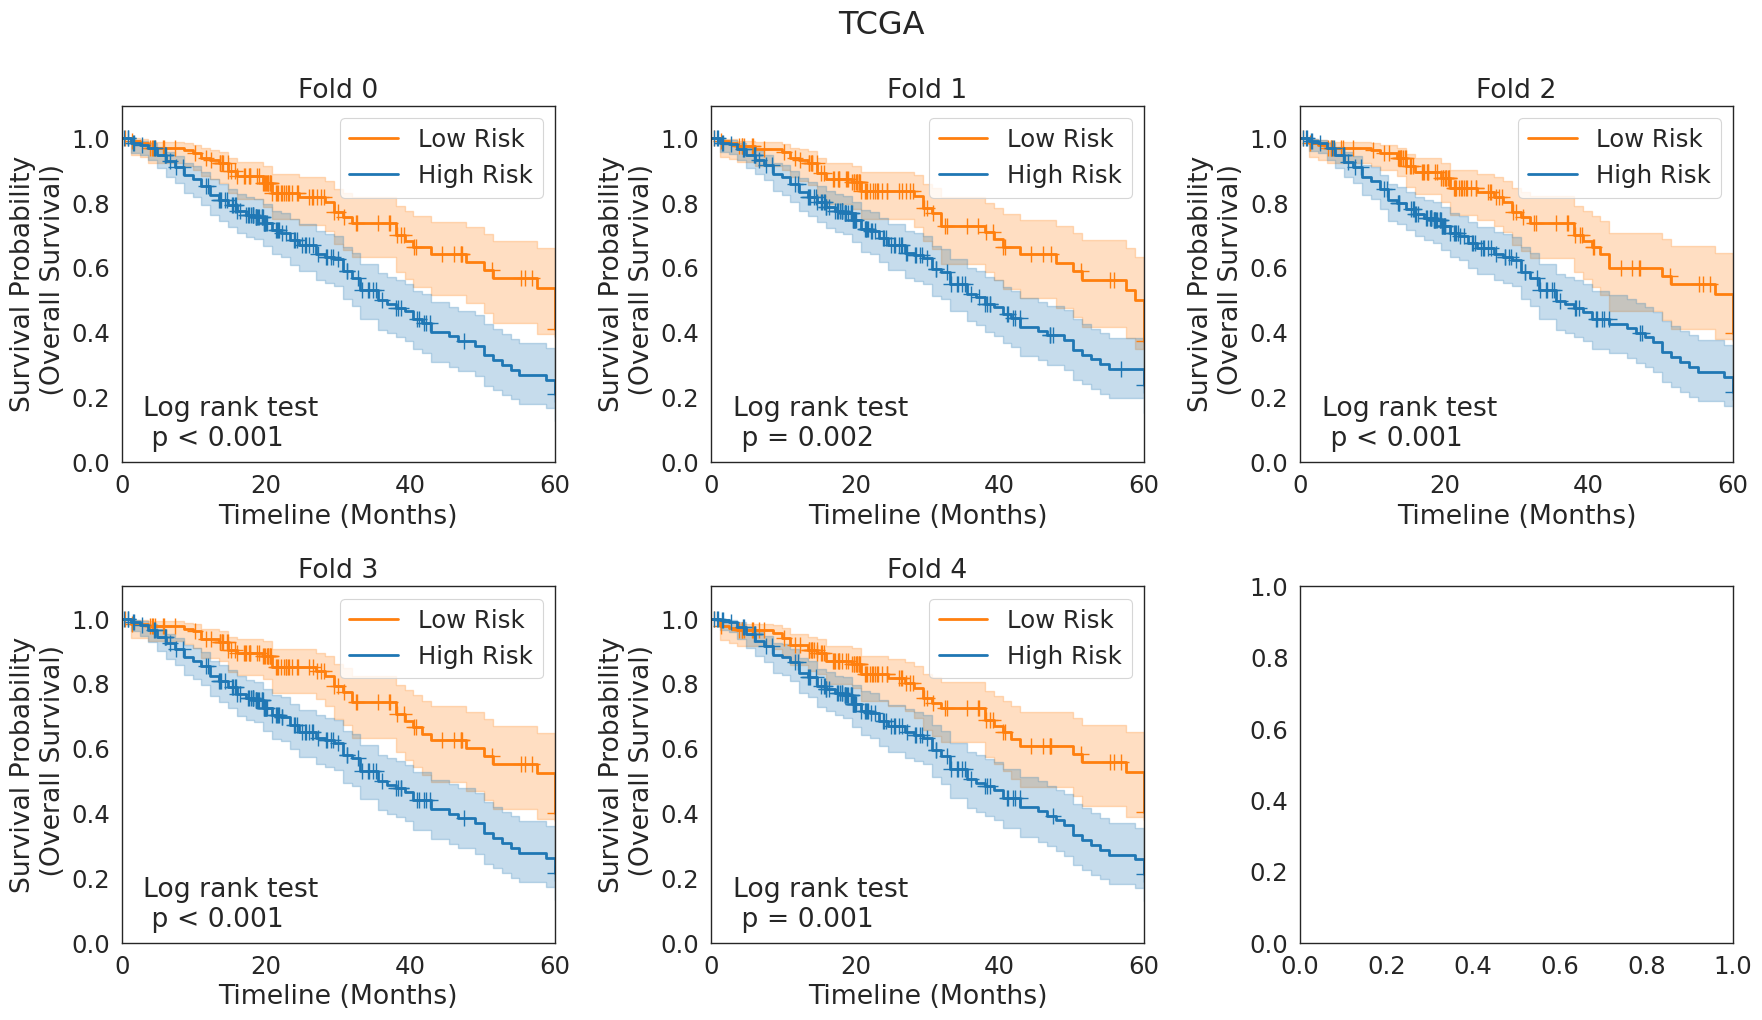

In [32]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,10.5))
axs = axs.flatten()

for i in range(5):
    risk_groups = high_low[i]
    risk_groups = risk_groups[risk_groups['original_set'] == 'additional']
    plot_km_two_groups(risk_groups, event_ind_field, event_data_field, f'h_bin_{i}', 60, add_counts=False, title=f'Fold {i}', ax=axs[i])
# plot_km_two_groups(additional_risk_groups, event_ind_field, event_data_field, 'risk', 60, title='External test set', ax=ax2)

plt.suptitle('TCGA')
plt.tight_layout()
plt.show()

p = 0.002


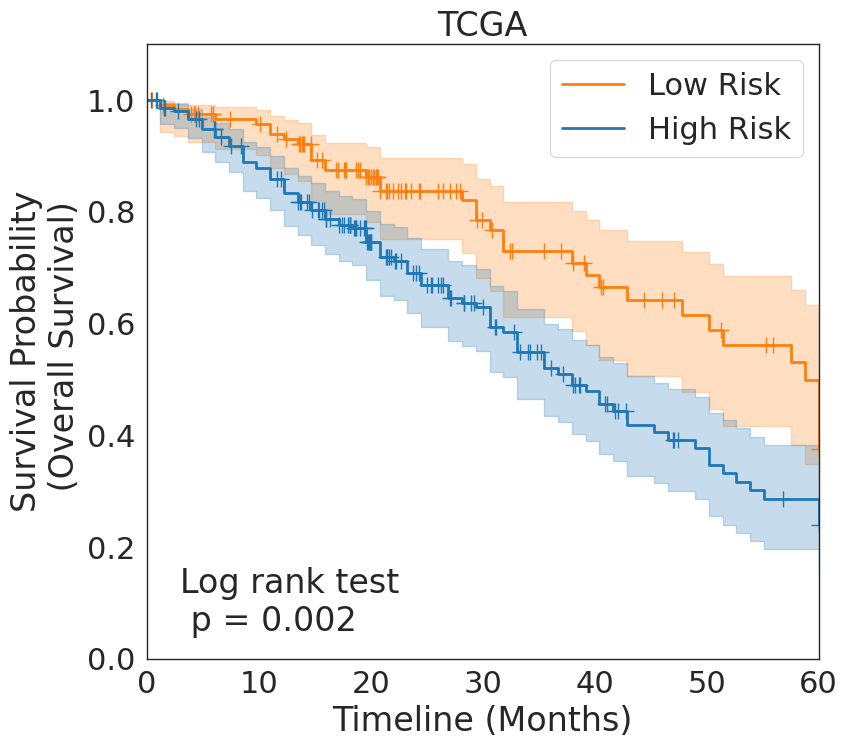

In [36]:
fig, ax = plt.subplots(figsize=(9,8))
fold = 1

risk_groups = high_low[fold]
risk_groups = risk_groups[risk_groups['original_set'] == 'additional']
plot_km_two_groups(risk_groups, event_ind_field, event_data_field, f'h_bin_{fold}', 60, add_counts=False, title='TCGA', ax=ax)


In [13]:
risk_groups = high_low[fold]
risk_groups = risk_groups[risk_groups['original_set'] == 'additional']

risk_groups[f'h_bin_{fold}'].value_counts()

1    197
0    142
Name: h_bin_4, dtype: int64